## [Source code](https://github.com/ebwieman/ebwieman.github.io/blob/main/posts/linear-regression/linear_regression.py)

## Implementing Linear Regression
In this blog post I implement linear regression in two ways: analytically, using an equation that solves for the optimal model weights, and using gradient descent, similar to the methods used in my prior logistic regression blog post. The implementation of linear regression is similar to logistic regression, but rather than calculating binary labels for a given data point, it calculates a specific value based on a data point's features. This is what differentiates regression tasks (predicting a number) from classification tasks (predicting a label). To calculate optimal weights analytically, the following formula was used (taken from lecture notes): $$\mathbf{\hat{w}}=\mathbf{(X^TX)^{-1}X^Ty}.$$ When implementing linear regression with gradient descent, the gradient was calculated with (from blog assignment description): $$\mathbf{\nabla L(w)}=\mathbf{X^T(Xw-y)},$$ and used to perform weight updates as done when using gradient descent for logistic regression. Both methods produced the same weights and were able to achieve relatively high accuracies on training and validation data. Experiments were done to analyze overfitting as the number of features were increased, and LASSO regularization was employed to minimize overfitting with increasing features. Lastly, I use my linear regression model to predict trends in casual bikeshare usage in Washington DC, finding that my model is able to learn trends in bikeshare usage relatively well.

### Testing Two Implementations
Before testing my two fitting techniques, I have to generate some data. I have generated both training and validation data, visualized below. We can see the two datasets exhibit similar trends, so my model trained on the training data, should generalize to the validation data relatively well.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

def LR_data(n_train = 100, n_val = 100, p_features = 1, noise = .1, w = None):
    if w is None: 
        w = np.random.rand(p_features + 1) + .2
    
    X_train = np.random.rand(n_train, p_features)
    y_train = pad(X_train)@w + noise*np.random.randn(n_train)

    X_val = np.random.rand(n_val, p_features)
    y_val = pad(X_val)@w + noise*np.random.randn(n_val)
    
    return X_train, y_train, X_val, y_val

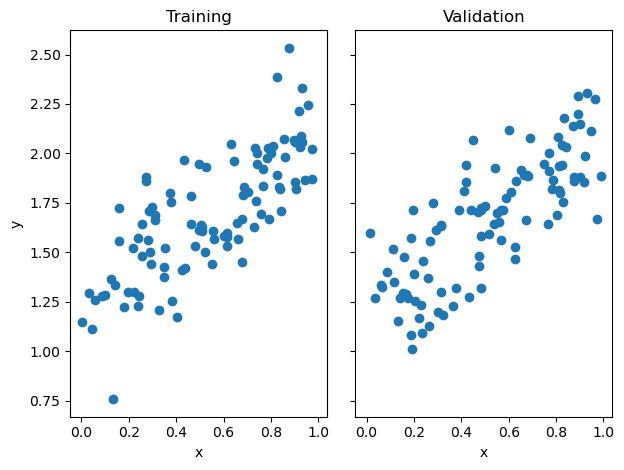

In [2]:
n_train = 100
n_val = 100
p_features = 1
noise = 0.2

# create some data
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()

Next I import the model and test it, first fitting the data using the analytical technique desribed above. When we print the accuracies, we see a training score of 0.59 and a validation score of 0.62. The model actually performs better on the validation data! This is encouraging, as it means we are likely not overfitting.

In [3]:
from linear_regression import LinearRegression

LR = LinearRegression()
LR.fit(X_train, y_train) # I used the analytical formula as my default fit method

print(f"Training score = {LR.score(X_train, y_train).round(4)}")
print(f"Validation score = {LR.score(X_val, y_val).round(4)}")

Training score = 0.5944
Validation score = 0.6242


We can visualize the results of our model, and we see that it does a good job of drawing a line that reflects trends in the data.

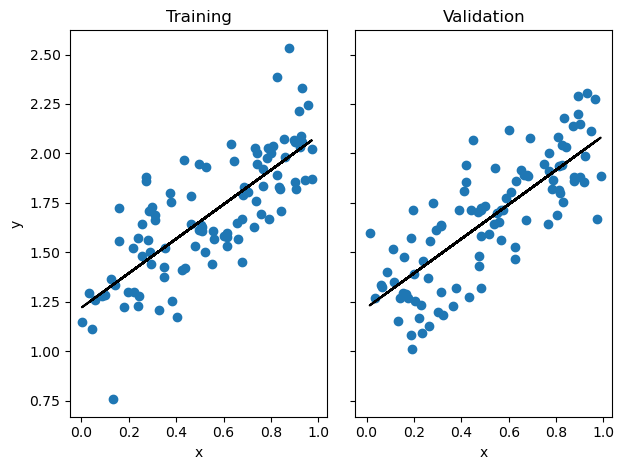

In [6]:
# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[0].plot(X_train, LR.predict(X_train), color = "black")
axarr[1].scatter(X_val, y_val)
axarr[1].plot(X_val, LR.predict(X_val), color = "black")
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()

When we print the weights of the model fit using analytical methods and compare it to the model weights when using gradient descent, we see that we get the same weights, as we would expect. If we trained the gradient descent model on more epochs, we would likely see even more agreement in the later decimal places.

In [4]:
LR.w

array([1.09501024, 0.88755776])

In [5]:
LR2 = LinearRegression()

LR2.fit(X_train, y_train, method = "gradient", alpha = 0.01, max_epochs = 1e2)
LR2.w

array([1.09428466, 0.88794095])

We can also plot the score history of the gradient descent model and we see an initial steep increase in the score, as expected, before plateauing around 0.7 after about 20 iterations.

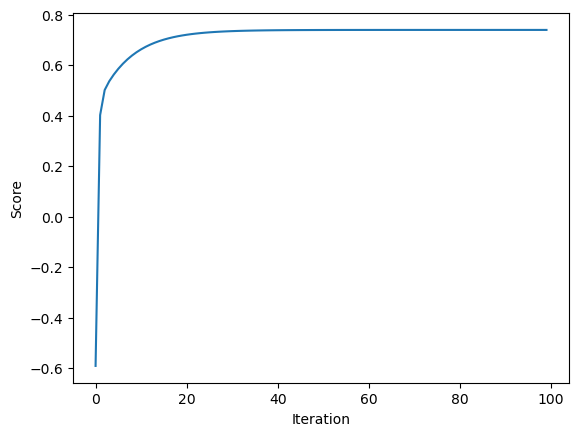

In [6]:
plt.plot(LR2.score_history)
labels = plt.gca().set(xlabel = "Iteration", ylabel = "Score")

### Experimenting with Number of Features
Next we increase the number of features and see how this impacts model performance on both training and validation data. We see that as we increase the number of features, the training score also increases before plateauing around 1.0, the highest possible value. The validation score initially increases as well, but then sharply declines to values below zero, indicating very poor performance, as the number of features approaches the number of data points. This is due to overfitting. As we increase the number of features to get closer to the number of data points, the model has a difficult time generalizing and extracting patterns because there is not enough data. This negatively impacts the validation score because rather than extracting general patterns, the model simply learns the exact behavior of the training dataset.

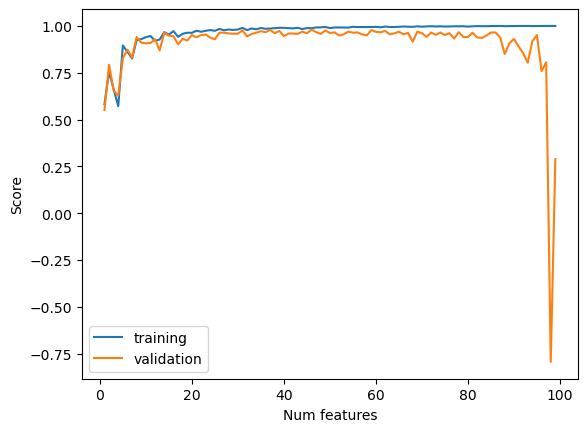

In [7]:
n_train = 100
n_val = 100
noise = 0.2

train_scores = []
val_scores = []
LR3 = LinearRegression()

for i in range(1,n_train):
    p_features = i
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    LR3.fit(X_train, y_train)
    train_scores.append(LR3.score(X_train, y_train).round(4))
    val_scores.append(LR3.score(X_val, y_val).round(4))
    
plt.plot(np.arange(1,n_train),train_scores, label = "training")
plt.plot(np.arange(1,n_train),val_scores, label = "validation")

labels = plt.gca().set(xlabel = "Num features", ylabel = "Score")

legend = plt.legend()

To combat this, we utilize LASSO regularization. LASSO regularization constrains the weight vector to be small, forcing many weights to be zero. This minimizes the effects of overfitting because it constrains the number of features that actually contribute to the model's final predictions. When we employ LASSO regularization with an alpha of 0.001 we see a dip in later validation scores, but it is much smaller, dipping from about 1.0 to 0.8, rather than falling to almost -0.75.

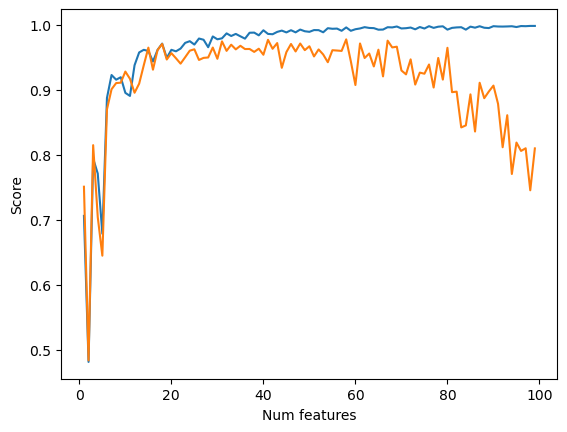

In [8]:
from sklearn.linear_model import Lasso

n_train = 100
n_val = 100
noise = 0.2

train_scores = []
val_scores = []
L = Lasso(alpha = 0.001)

for i in range(1,n_train):
    p_features = i
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    train_scores.append(L.score(X_train, y_train).round(4))
    val_scores.append(L.score(X_val, y_val).round(4))
    
plt.plot(np.arange(1,n_train),train_scores, label = "training")
plt.plot(np.arange(1,n_train),val_scores, label = "validation")

labels = plt.gca().set(xlabel = "Num features", ylabel = "Score")

legend = plt.legend()

Experimenting with different alpha values, we see that when we increase alpha to 0.01 the score dips further. When we decrease alpha to 0.0001, we see similar behavior to our original alpha value of 0.001, with a slightly smaller dip.

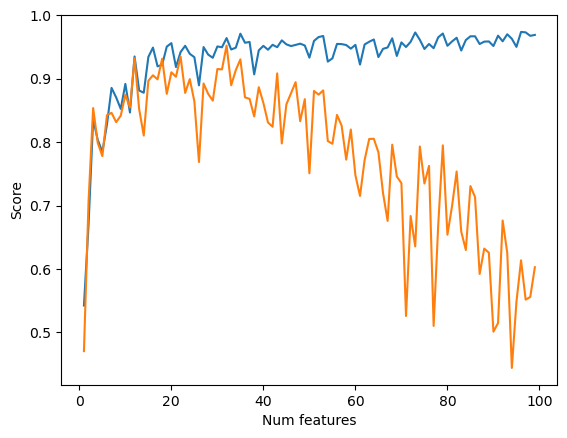

In [9]:
from sklearn.linear_model import Lasso

n_train = 100
n_val = 100
noise = 0.2

train_scores = []
val_scores = []
L = Lasso(alpha = 0.01)

for i in range(1,n_train):
    p_features = i
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    train_scores.append(L.score(X_train, y_train).round(4))
    val_scores.append(L.score(X_val, y_val).round(4))
    
plt.plot(np.arange(1,n_train),train_scores, label = "training")
plt.plot(np.arange(1,n_train),val_scores, label = "validation")

labels = plt.gca().set(xlabel = "Num features", ylabel = "Score")

legend = plt.legend()

/Users/elizawieman/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e-01, tolerance: 4.254e-02
  model = cd_fast.enet_coordinate_descent(


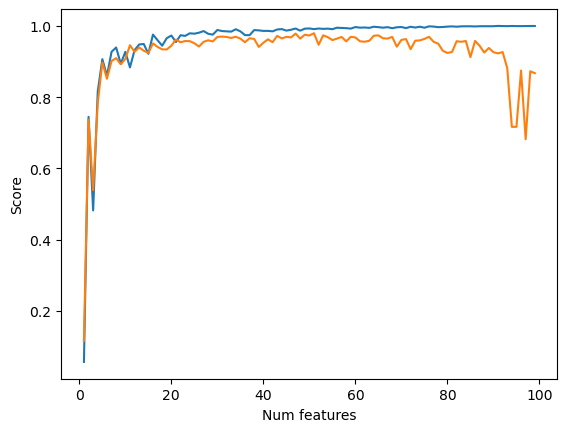

In [10]:
from sklearn.linear_model import Lasso

n_train = 100
n_val = 100
noise = 0.2

train_scores = []
val_scores = []
L = Lasso(alpha = 0.0001)

for i in range(1,n_train):
    p_features = i
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L.fit(X_train, y_train)
    train_scores.append(L.score(X_train, y_train).round(4))
    val_scores.append(L.score(X_val, y_val).round(4))
    
plt.plot(np.arange(1,n_train),train_scores, label = "training")
plt.plot(np.arange(1,n_train),val_scores, label = "validation")

labels = plt.gca().set(xlabel = "Num features", ylabel = "Score")

legend = plt.legend()

### Analyzing Trends in Bikeshare Usage with Linear Regression
Lastly, we use our linear regression model to predict trends in the casual usage of bikeshare programs in Washington DC. First we import the data, visualize trends, and do some data cleaning in preparation for model training and prediction.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
bikeshare = pd.read_csv("https://philchodrow.github.io/PIC16A/datasets/Bike-Sharing-Dataset/day.csv")

bikeshare.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


First let's visualize the data. We see the number of casual users fluctuate seasonally, as well as within each month, perhaps depending on weather patterns or time of week.

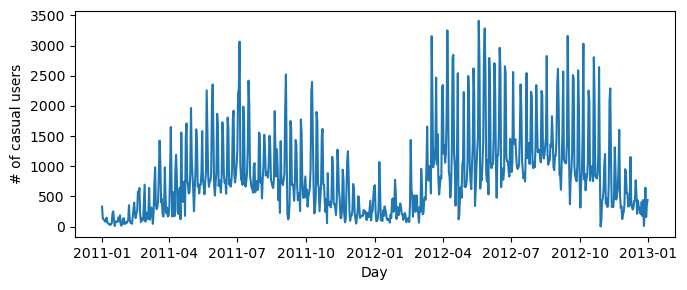

In [12]:
# import datetime
fig, ax = plt.subplots(1, figsize = (7, 3))
ax.plot(pd.to_datetime(bikeshare['dteday']), bikeshare['casual'])
ax.set(xlabel = "Day", ylabel = "# of casual users")
l = plt.tight_layout()

Next we extract relevant information for our model and split our dataset for testing and training.

In [13]:
cols = ["casual", 
        "mnth", 
        "weathersit", 
        "workingday",
        "yr",
        "temp", 
        "hum", 
        "windspeed",
        "holiday"]

bikeshare = bikeshare[cols]

bikeshare = pd.get_dummies(bikeshare, columns = ['mnth'], drop_first = "if_binary")
bikeshare

,casual,weathersit,workingday,yr,temp,hum,windspeed,holiday,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12
0,331,2,0,0,0.344167,0.805833,0.160446,0,0,0,0,0,0,0,0,0,0,0,0
1,131,2,0,0,0.363478,0.696087,0.248539,0,0,0,0,0,0,0,0,0,0,0,0
2,120,1,1,0,0.196364,0.437273,0.248309,0,0,0,0,0,0,0,0,0,0,0,0
3,108,1,1,0,0.200000,0.590435,0.160296,0,0,0,0,0,0,0,0,0,0,0,0
4,82,1,1,0,0.226957,0.436957,0.186900,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,247,2,1,1,0.254167,0.652917,0.350133,0,0,0,0,0,0,0,0,0,0,0,1
727,644,2,1,1,0.253333,0.590000,0.155471,0,0,0,0,0,0,0,0,0,0,0,1
728,159,2,0,1,0.253333,0.752917,0.124383,0,0,0,0,0,0,0,0,0,0,0,1
729,364,1,0,1,0.255833,0.483333,0.350754,0,0,0,0,0,0,0,0,0,0,0,1


In [14]:
train, test = train_test_split(bikeshare, test_size = .2, shuffle = False)

X_train = train.drop(["casual"], axis = 1)
y_train = train["casual"]

X_test = test.drop(["casual"], axis = 1)
y_test = test["casual"]

Finally we fit our model, and visualize the test predictions alongside the actual data. We see that our model is able to reproduce the general trends in casual usage, although tends to predict smaller fluctuations in usage (lower maxima, higher minima) than the actual data shows.

In [15]:
LR4 = LinearRegression()

LR4.fit(X_train, y_train)
LR4.score(X_test, y_test)

y_pred = LR4.predict(X_test)

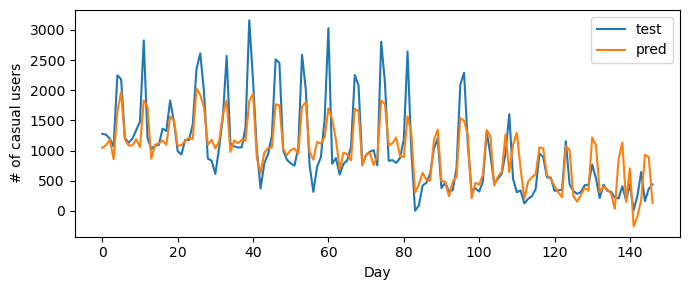

In [21]:
fig, ax = plt.subplots(1, figsize = (7, 3))
ax.plot(np.arange(len(y_test)), y_test, label="test")
ax.plot(np.arange(len(y_test)), y_pred, label="pred")
ax.set(xlabel = "Day", ylabel = "# of casual users")
l = plt.tight_layout()

legend = plt.legend()

Finally, we can examine which factors the model considers to be contributing the most to usage. The highest weight in our model contributes to the variable temperature, meaning that our model considers temperature to be a very important factor in determining casual bike usage. This makes sense, as people would probably be more likely to ride a bike on a warmer day. The weight corresponding to windspeed is the most negative value by far. This also makes sense, as a high windspeed would likely discourage people from wanting to bike outside. We also see trends by month, with higher weights attributed to the spring and fall months, some of the nicest bike weather, and lower weights attributed to summer and winter months, when it could be to hot or cold to ride comfortably. We also see that people are less likely to use bikeshares on working days and holidays, suggesting that much of the casual bikeshare usage happens on the weekends.

In [27]:
print(LR4.w)
print(X_train.columns)

[ -108.37113627  -791.69054913   280.58692733  1498.71511272
  -490.10033978 -1242.80038075  -235.87934918    -3.35439712
   369.27195552   518.40875345   537.30188616   360.80799815
   228.88148125   241.31641202   371.50385387   437.60084787
   252.43300405    90.8214605    919.07676215]
Index(['weathersit', 'workingday', 'yr', 'temp', 'hum', 'windspeed', 'holiday',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')
